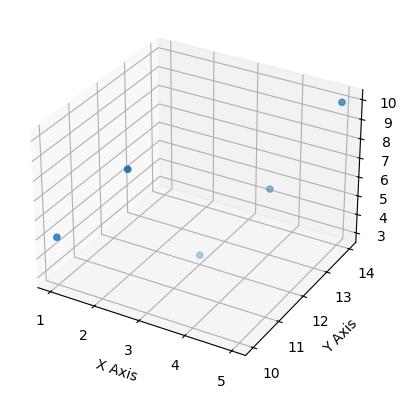

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data
x = [1, 2, 3, 4, 5]
y = [10, 11, 12, 13, 14]
z = [5, 8, 3, 6, 10]

# Create a 3D figure
fig = plt.figure()

# Add 3D axes to the figure
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot
ax.scatter(x, y, z)

# Set labels for each axis
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show the plot
plt.show()


In [3]:
import nilearn as nl
import nibabel as nib
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

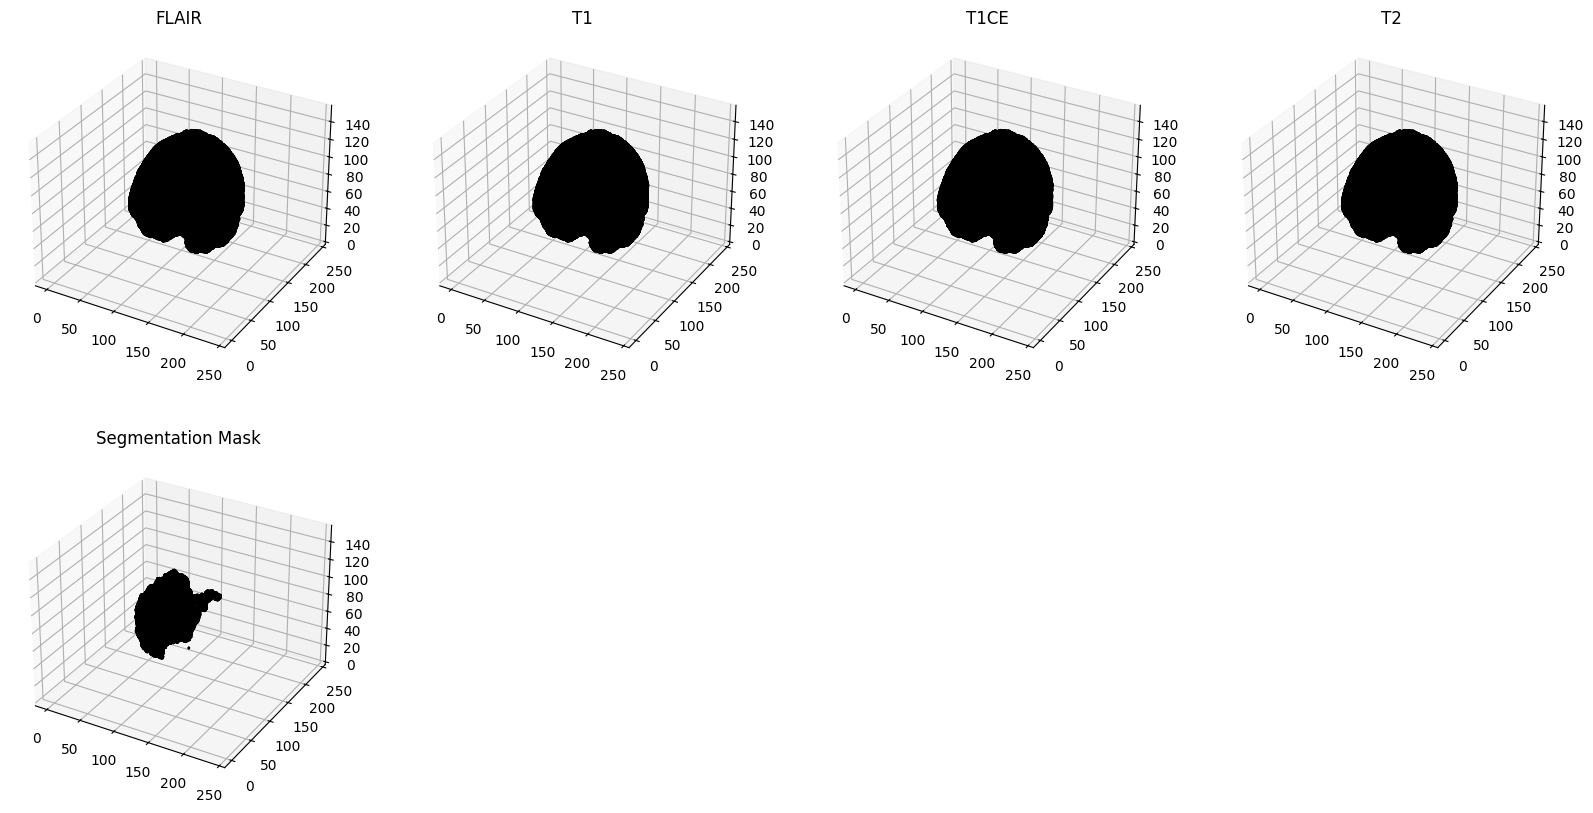

In [5]:
fig = plt.figure(figsize=(20, 10))

# Plot the FLAIR image
ax_flair = fig.add_subplot(241, projection='3d')
ax_flair.set_title('FLAIR')
ax_flair.voxels(test_image_flair, edgecolors='k')

# Plot the T1 image
ax_flair = fig.add_subplot(242, projection='3d')
ax_flair.set_title('T1')
ax_flair.voxels(test_image_flair, edgecolors='k')

# Plot the T1CE image
ax_t1ce = fig.add_subplot(243, projection='3d')
ax_t1ce.set_title('T1CE')
ax_t1ce.voxels(test_image_t1ce, edgecolors='k')

# Plot the T2 image
ax_t2 = fig.add_subplot(244, projection='3d')
ax_t2.set_title('T2')
ax_t2.voxels(test_image_t2, edgecolors='k')

# Plot the Segmentation mask
ax_mask = fig.add_subplot(245, projection='3d')
ax_mask.set_title('Segmentation Mask')
ax_mask.voxels(test_mask, edgecolors='k', facecolors='r', alpha=0.4)

plt.show()

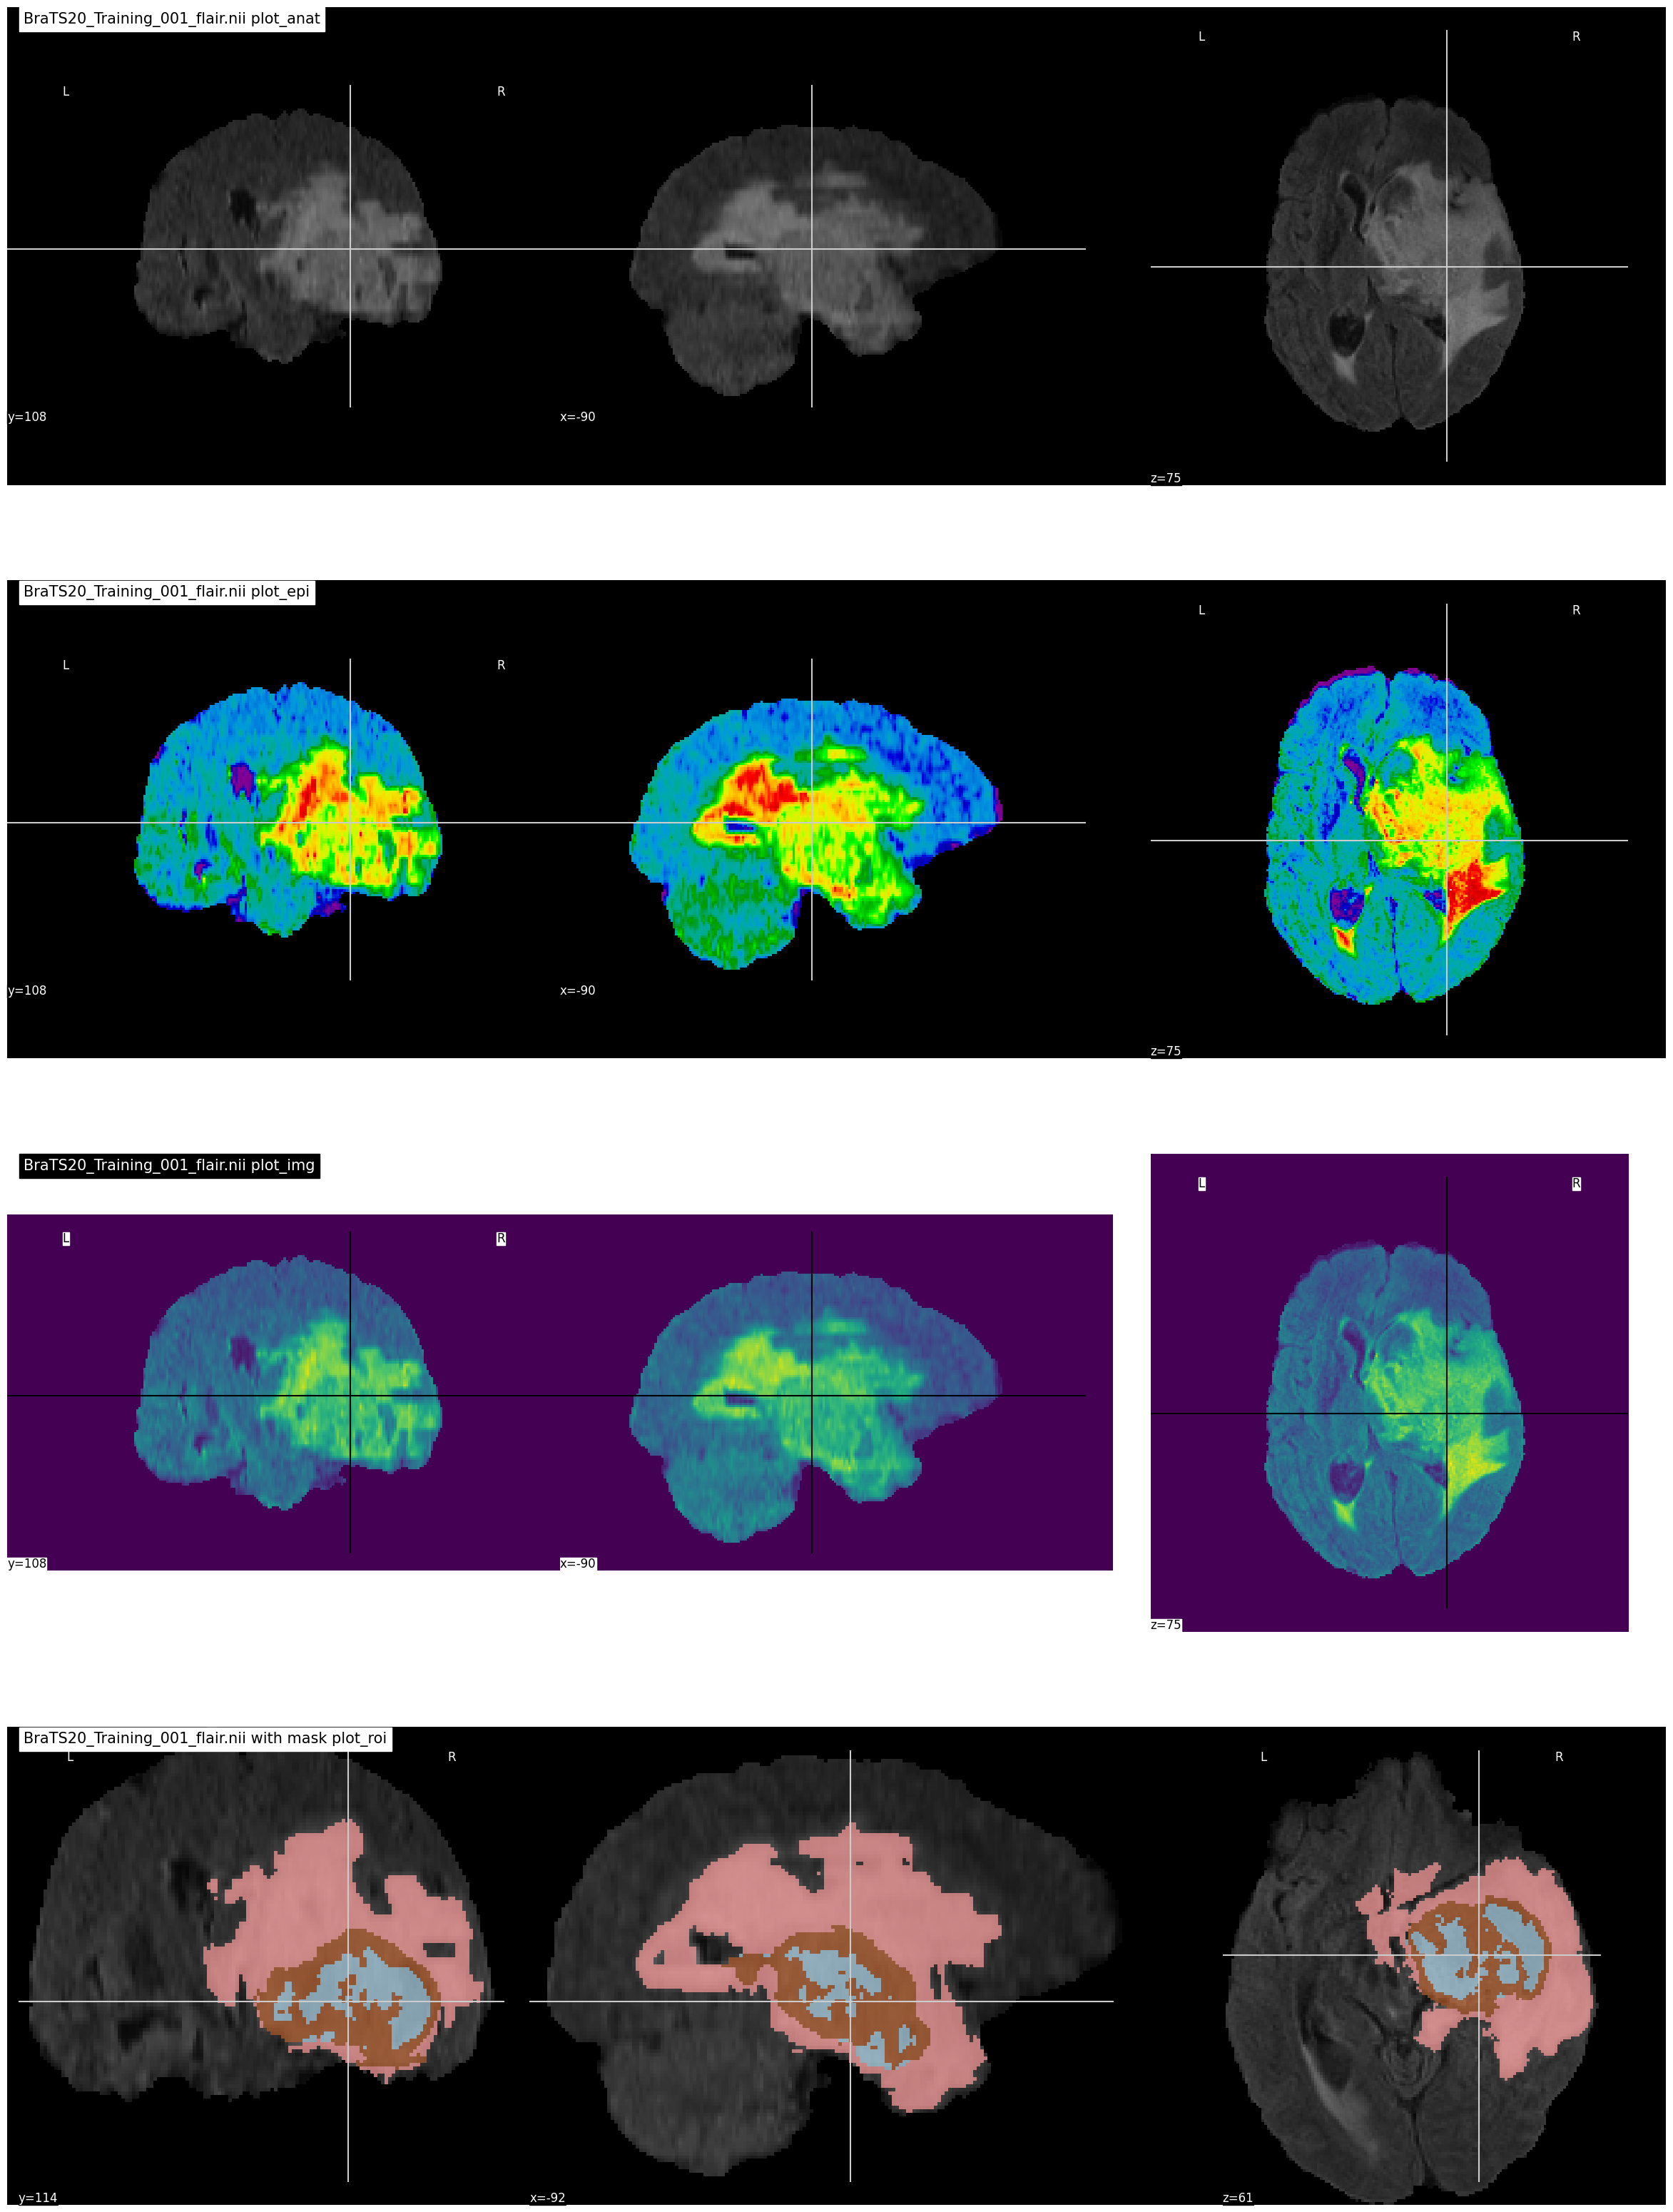

In [6]:
import nilearn.plotting as nlplt
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()


In [7]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from keras import backend as K
def dice_coefficient(y_true, y_pred, smooth=1e-5, num_classes=4):
    dice_scores = []

    for i in range(num_classes):
        intersection = np.sum((y_true == i) & (y_pred == i))
        true_mask = np.sum(y_true == i)
        pred_mask = np.sum(y_pred == i)
        
        dice = (2.0 * intersection + smooth) / (true_mask + pred_mask + smooth)
        dice_scores.append(dice)

    average_dice = np.mean(dice_scores)
    return average_dice

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = np.sum((y_true == 1)& (y_pred == 1))
    true_mask = np.sum(y_true == 1)
    pred_mask = np.sum(y_pred == 1)
    
    dice = (2.0 * intersection + epsilon) / (true_mask + pred_mask + epsilon)
    
    return dice
    
def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = np.sum((y_true == 2)& (y_pred == 2))
    true_mask = np.sum(y_true == 2)
    pred_mask = np.sum(y_pred == 2)
    
    dice = (2.0 * intersection + epsilon) / (true_mask + pred_mask + epsilon)
    
    return dice


def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = np.sum((y_true == 3)& (y_pred == 3))
    true_mask = np.sum(y_true == 3)
    pred_mask = np.sum(y_pred == 3)
    
    dice = (2.0 * intersection + epsilon) / (true_mask + pred_mask + epsilon)
    
    return dice

def dice_coef_not_tumor(y_true, y_pred, epsilon=1e-6):
    intersection = np.sum((y_true == 0)& (y_pred == 0))
    true_mask = np.sum(y_true == 0)
    pred_mask = np.sum(y_pred == 0)
    
    dice = (2.0 * intersection + epsilon) / (true_mask + pred_mask + epsilon)
    
    return dice

def hausdorff_distance(mask1, mask2):
    # Find the coordinates of non-zero elements in the binary masks
    points_mask1 = np.array(np.where(mask1)).T
    points_mask2 = np.array(np.where(mask2)).T

    # Calculate the directed Hausdorff distance in both directions
    distance_1_to_2 = directed_hausdorff(points_mask1, points_mask2)[0]
    distance_2_to_1 = directed_hausdorff(points_mask2, points_mask1)[0]

    # Return the maximum of the two distances
    hausdorff_dist = max(distance_1_to_2, distance_2_to_1)
    return hausdorff_dist

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [8]:
IMG_SIZE =128

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, UpSampling3D,  Input,  concatenate, Dropout
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

def build_unet(inputs,ker_init, dropout):
    conv1 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling3D(pool_size=(2, 2,2))(conv1)
    conv = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling3D(pool_size=(2, 2,2))(conv)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2,2))(conv2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    conv5 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 4)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv3D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 4)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv3D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 4)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    up = Conv3D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(conv9))
    merge = concatenate([conv1,up], axis = 4)
    conv = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv3D(4, (1,1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE,2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), 
                         dice_coefficient, precision, sensitivity, 
                         specificity, dice_coef_necrotic, dice_coef_edema ,
                         dice_coef_enhancing, dice_coef_not_tumor, hausdorff_distance] )

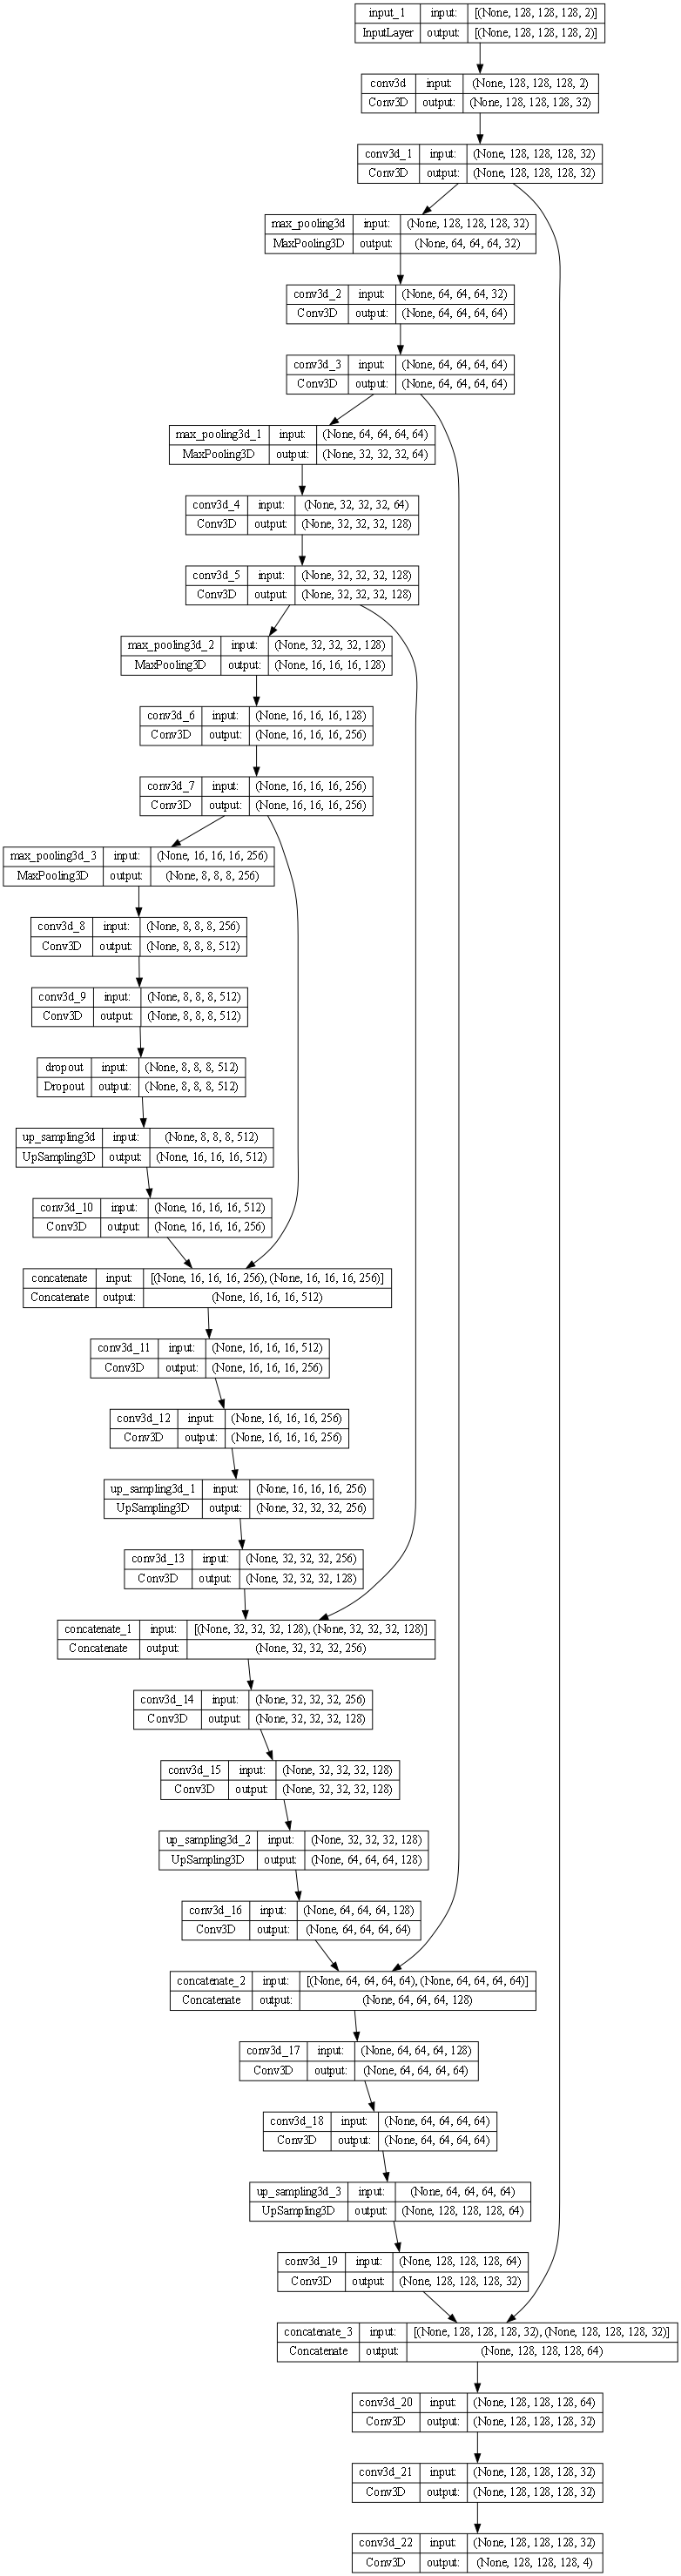

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)